In [1]:
!git clone https://github.com/DrYogurt/Aero-Design-Team-Gamma.git
!pip install poetry==1.4.2

Cloning into 'Aero-Design-Team-Gamma'...
remote: Enumerating objects: 294, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 294 (delta 18), reused 18 (delta 8), pack-reused 254 (from 1)
Receiving objects: 100% (294/294), 41.72 MiB | 13.63 MiB/s, done.
Resolving deltas: 100% (132/132), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of poetry-plugin-export to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of virtualenv to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of virtualenv to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter c

In [2]:
%cd Aero-Design-Team-Gamma
!poetry config virtualenvs.in-project true
!poetry install --no-ansi

/content/Aero-Design-Team-Gamma
Creating virtualenv aerospace-design-team-gamma in /content/Aero-Design-Team-Gamma/.venv
Installing dependencies from lock file
The lock file might not be compatible with the current version of Poetry.
Upgrade Poetry to ensure the lock file is read properly or, alternatively, regenerate the lock file with the `poetry lock` command.

Package operations: 137 installs, 1 update, 0 removals

  • Installing attrs (25.1.0)
  • Installing rpds-py (0.22.3)
  • Installing typing-extensions (4.12.2)
  • Installing referencing (0.36.2)
  • Installing six (1.17.0)
  • Installing jsonschema-specifications (2024.10.1)
  • Installing platformdirs (4.3.6)
  • Installing python-dateutil (2.9.0.post0)
  • Installing traitlets (5.14.3)
  • Installing types-python-dateutil (2.9.0.20241206)
  • Installing arrow (1.3.0)
  • Installing fastjsonschema (2.21.1)
  • Installing jsonschema (4.23.0)
  • Installing jupyter-core (5.7.2)
  • Installing pycparser (2.22)
  • Installing p

In [3]:
VENV_PATH = "/content/Aero-Design-Team-Gamma/.venv/lib/python3.11/site-packages"
import os, sys
LOCAL_VENV_PATH = '/content/venv' # local notebook
os.symlink(VENV_PATH, LOCAL_VENV_PATH) # connect to directory in drive
sys.path.insert(0, LOCAL_VENV_PATH)

FileExistsError: [Errno 17] File exists: '/content/Aero-Design-Team-Gamma/.venv/lib/python3.11/site-packages' -> '/content/venv'

In [4]:
from ambiance import Atmosphere
import numpy as np
import matplotlib.pyplot as plt
import sympy

from global_variables.solver import EquationSystem
from global_variables.registry import VariableRegistry, Variable

registry = VariableRegistry("aero_vars.yaml")

In [5]:
outputs = {"S_TO", "R", "sigma_max"}
#outputs = {"R", "sigma_max"}

# Create solvers for each output
solvers = {
    output: EquationSystem(registry, {output})
    for output in outputs
}

# Get all unique inputs
all_inputs = set().union(*(solver.inputs for solver in solvers.values()))
print(f"Required inputs: {all_inputs}")
solvers

Required inputs: {'rho_h', 'V', 'We_Wmax', 'T_A0', 'TSFC', 'n_pax', 'mu', 'e', 'W_max', 'W_pax', 'C_D0', 'b', 'C_Lmax', 'rho', 'S_'}


{'sigma_max': <global_variables.solver.EquationSystem at 0x7b50c2e68dd0>,
 'S_TO': <global_variables.solver.EquationSystem at 0x7b509125e650>,
 'R': <global_variables.solver.EquationSystem at 0x7b50c3794a10>}

In [6]:
Rf = solvers["R"].create_solver()
S_TOf = solvers["S_TO"].create_solver()

R_func = Rf["R"]
S_TO_func = S_TOf["S_TO"]


In [7]:
fuel_QRs = {
"JP":	43100.00,
"CH4":	50000.00,
"H2":	120000.00
}
def create_tsfcs(jp_tsfc):
    tsfcs = {}
    for fuel,qr in fuel_QRs.items():
        tsfcs[fuel] = jp_tsfc * fuel_QRs["JP"] / qr
    return tsfcs
create_tsfcs(0.5)

{'JP': 0.5, 'CH4': 0.431, 'H2': 0.17958333333333334}

In [8]:
def velocity(M,h):
  atmo = Atmosphere(h * 0.3048)
  return atmo.speed_of_sound[-1] * M / 0.3048
def rho_func(h):
  atmo = Atmosphere(h * 0.3048)
  return atmo.density[-1] * 0.00194032

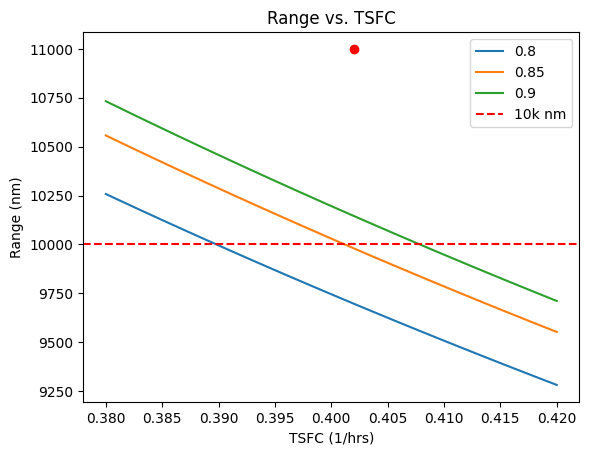

In [9]:
def R_vs_TSFC(cT,M):
  return R_func(C_D0=0.025,
         S_=10200,
         TSFC=cT/3600,
         V=velocity(M=M,h=3.5e4),
         W_max=2e6,
         W_pax=205,
         We_Wmax=.46,
         b=315,
         e=0.9,
         n_pax=1255,
         rho_h=rho_func(3.5e4))

cTs = np.linspace(0.38,0.42,100)
Rs = {M : R_vs_TSFC(cTs,M) for M in [0.8,0.85,0.9]}

for M,R in Rs.items():
  plt.plot(cTs,R/6017,label=M)
plt.xlabel("TSFC (1/hrs)")
plt.ylabel("Range (nm)")
plt.title("Range vs. TSFC")
# horizontal line at 10k
plt.axhline(y=10e3, color='r', linestyle='--',label="10k nm")
# our point here
plt.scatter(.402,1.1e4,marker='o',c='r')
plt.legend()


plt.show()

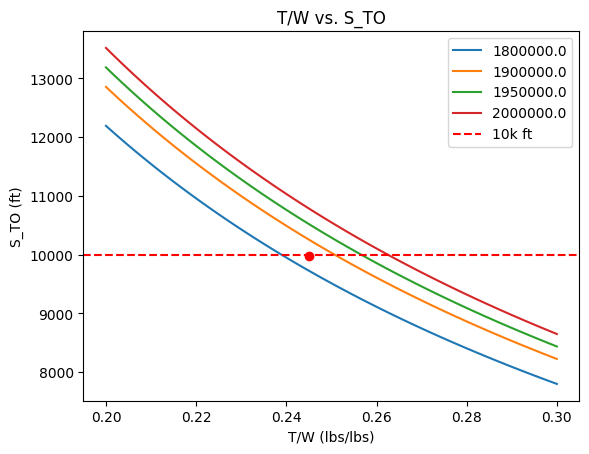

In [10]:
def TW_vs_S_TO(TW,max_weight=2e6):
    thrust = TW * max_weight
    return S_TO_func(C_D0=0.025,
         S_=10200,
         W_max=max_weight,
         b=315,
         e=0.9,
         C_Lmax=1.56,
         T_A0=thrust,
         mu=.02,
         rho=rho_func(0)
    )

TWs = np.linspace(0.2,0.3,100)
lines = {W : TW_vs_S_TO(TWs,W) for W in [1.8e6,1.9e6,1.95e6,2e6]}
#print(lines)
for W,TW in lines.items():
  plt.plot(TWs,TW,label=W)
plt.xlabel("T/W (lbs/lbs)")
plt.ylabel("S_TO (ft)")
plt.title("T/W vs. S_TO")
# horizontal line at 10k
plt.axhline(y=10e3, color='r', linestyle='--',label="10k ft")

# our point here
plt.scatter(.245,9980,marker='o',c='r')
plt.legend()


plt.show()